# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

import matplotlib

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df = df.astype({'article_id': 'int32'})
df.head()

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content = df_content.astype({'article_id': 'int32'})
df_content.head()


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
#Create grouped_df to count interactions of specific users with articles
grouped_df_user_item = df.groupby('email')
grouped_df_user_item = grouped_df_user_item.agg({'article_id': 'nunique'})
grouped_df_user_item = grouped_df_user_item.reset_index()

grouped_df_user_item.head()


,email,article_id
0,0000b6387a0366322d7fbfc6434af145adf7fed1,12
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,5
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


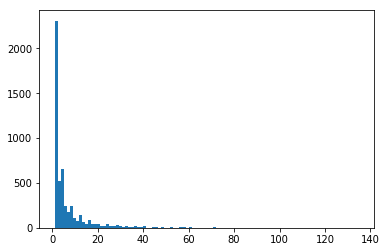

In [4]:
#What is the distribution of how many articles a user interacts with in the dataset?
matplotlib.pyplot.hist(grouped_df_user_item['article_id'], bins = 100);

In [5]:
#Max views for one user (seperate articles)
max_views_per_user_unique = grouped_df_user_item.max()['article_id']
max_views_per_user_unique

135

In [6]:
#Max views for one user (incl interactions with the same articles)
max_views_per_user = df.groupby('email').count().max().max()
max_views_per_user

364

In [7]:
#Calc median of user-article interactions
median_views = grouped_df_user_item.median().iloc[0].astype(int)
median_views

3

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = median_views # 50% of individuals interact with ______ number of articles or fewer.
max_views_by_user = max_views_per_user # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [10]:
# Remove any rows that have the same doc_full_name - only keep the first
df_content['doc_full_name'].drop_duplicates(keep = 'first', inplace = True)
df_content.shape

(1056, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
#a. The number of unique articles that have an interaction with a user.
unique_inter = df.drop_duplicates(subset=['title'], keep = 'first').count()[0]
unique_inter

714

In [12]:
#b  The number of unique articles in the dataset (whether they have any interactions or not).
unqiue_articles = df_content.reset_index().drop_duplicates(subset=['doc_full_name'], keep = 'first', inplace = False).count()[0]
unqiue_articles

1051

In [13]:
#c. The number of unique users in the dataset. (excluding null values)
unique_users = df['email'].dropna().nunique()
unique_users

5148

In [14]:
#d. The number of user-article interactions in the dataset.
len(df)

45993

In [15]:
unique_articles = unique_inter #The number of unique articles that have at least one interaction
total_articles = unqiue_articles # The number of unique articles on the IBM platform
unique_users = unique_users # The number of unique users
user_article_interactions = len(df) # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
#Most Views
most_views = df.groupby('article_id').count().sort_values(by = ['title'],ascending = False)['title'].iloc[0]
most_views

937

In [17]:
#Most viewed article number
most_viewed_art = df.groupby('article_id').count().sort_values(by = ['title'],ascending = False).first_valid_index().astype('float').astype('str')
most_viewed_art

'1429.0'

In [18]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = most_viewed_art 

In [19]:
# The most viewed article in the dataset was viewed how many times?
max_views = most_views  # The most viewed article in the dataset was viewed how many times?

In [20]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #Identify most popular items by occurance of title
    n_largest = df['title'].value_counts().nlargest(n)
    
    #Create list from n_largest items
    top_articles = list(n_largest.index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #Identify most popular items by occurance of article_id
    n_largest = df['article_id'].value_counts().nlargest(n)
    
    #Create list from n_largest items
    top_articles = list(n_largest.index)
 
    return top_articles # Return the top article ids

In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [24]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [25]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create matrix of user-item interaction
    user_item = df.pivot_table(index='user_id', columns='article_id', values='title', aggfunc = pd.Series.nunique).fillna(0)
    
    #Change data type to int
    user_item = user_item.astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [26]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [27]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
           
    #Calculate dot product of matrix with transposed version to calculate similarity scores between users
    #To do: Could be improved to not calculate the full dot product every time, but only for relevant user id
    dot_prod_user_items = user_item.dot(np.transpose(user_item))
    
    #Define how man simlar users should be used (at the moment all other users)
    number_of_users = dot_prod_user_items.shape[0]
    
    #Set diagonal values to zero, to avoid recommendations to users based on similarity to themselves 
    np.fill_diagonal(dot_prod_user_items.values, 0)
    
    #Get most similar users compared to target user 


    most_similar_users = list(dot_prod_user_items[dot_prod_user_items.index == user_id].T.nlargest(number_of_users, user_id).index)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [28]:
# Do a spot check of your function
#print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
#print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
#print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [29]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df['article_id'].isin(article_ids)].drop_duplicates('title')
    article_names = list(article_names['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    #Get article ids a given user has interacted with
    #User_id starts at 1 and Row_index starts at 0
    article_ids = user_item.iloc[user_id-1, :]
    article_ids = list(pd.Series(article_ids).where(lambda x : x != 0).dropna().index) 
    
    #Get article names (doc_full_name) from df_content dataframe for relevant ids
    #article_names = df_content[df_content['article_id'].isin(article_ids)]
    #article_names = list(article_names['doc_full_name'])
    
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().values.tolist() 
    
    return article_ids, article_names # return the ids and names


In [30]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    #Get similar users
    similar_users = find_similar_users(user_id)
    
    #Create emtpy list for recommended ids & names
    recs = []
    recs_names = []
    
    #Loop through users in list of similar users until min. m recommendations are collected 
    for s in similar_users:
        if len(recs) < m:
            article_ids, article_names = get_user_articles(s)
        
            recs.extend(article_ids)
            recs_names.extend(article_names)
        
        else:
            break
    
    recs = recs[:10]
    recs_names = recs_names[:10]
             
    return recs, recs_names # return your recommendations for this user_id   

In [31]:
#Check results
recs, rec_names = user_user_recs(1, 10) # Return 10 recommendations for user 1
recs, rec_names

([43, 109, 268, 310, 329, 346, 390, 494, 525, 585],
 ['using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'use deep learning for image classification',
  'classify tumors with machine learning',
  'apache spark lab, part 1: basic concepts',
  'access db2 warehouse on cloud and db2 with python',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'putting a human face on machine learning',
  'gosales transactions for naive bayes model',
  'welcome to pixiedust'])

In [32]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function you wrote earlier.

In [33]:
#Find closest neighbors & sort by same closeness based on total article interactions
user_id = 1

#Calculate dot product of matrix with transposed version to calculate similarity scores between users
#To do: Could be improved to not calculate the full dot product every time, but only for relevant user id
dot_prod_user_items = user_item.dot(np.transpose(user_item))
 


In [34]:
#Define how man simlar users should be used (at the moment all other users)
number_of_users = dot_prod_user_items.shape[0]
    
#Set diagonal values to zero, to avoid recommendations to users based on similarity to themselves 
np.fill_diagonal(dot_prod_user_items.values, 0)
    
#Get most similar users compared to target user 

most_similar_users = list(dot_prod_user_items[dot_prod_user_items.index == user_id].T.nlargest(number_of_users, user_id).index)
       
most_similar_users

[3933,
 3782,
 23,
 203,
 4459,
 131,
 3870,
 46,
 4201,
 5041,
 49,
 395,
 3697,
 3910,
 3622,
 322,
 242,
 3764,
 290,
 2982,
 754,
 3540,
 98,
 4642,
 912,
 4785,
 135,
 371,
 621,
 5138,
 204,
 3784,
 52,
 256,
 3775,
 3621,
 3596,
 4134,
 4932,
 1355,
 273,
 268,
 3651,
 3637,
 40,
 21,
 765,
 4778,
 334,
 214,
 64,
 4755,
 3136,
 249,
 2926,
 4892,
 186,
 4293,
 619,
 184,
 488,
 4038,
 3483,
 3141,
 1897,
 696,
 3532,
 665,
 445,
 5079,
 5013,
 3024,
 10,
 656,
 187,
 125,
 4934,
 4706,
 3684,
 4774,
 288,
 54,
 4209,
 72,
 4484,
 3856,
 4206,
 2790,
 3632,
 67,
 3740,
 38,
 58,
 5140,
 60,
 4225,
 3354,
 3353,
 511,
 3358,
 362,
 733,
 195,
 170,
 3949,
 4595,
 3485,
 3794,
 4933,
 379,
 193,
 3693,
 4471,
 4404,
 807,
 295,
 409,
 263,
 261,
 2161,
 4277,
 2981,
 3169,
 1040,
 591,
 244,
 324,
 330,
 4883,
 235,
 2975,
 223,
 211,
 3006,
 1059,
 2430,
 4543,
 3408,
 3578,
 3818,
 8,
 113,
 4824,
 28,
 111,
 3879,
 69,
 90,
 3572,
 87,
 3197,
 3,
 689,
 670,
 4037,
 3710,
 1330

In [35]:
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [36]:
#Calculate total user-article interactions
user_interact = df.groupby('user_id').count().sort_values(by = ['title'],ascending = False)['title'].to_frame()

#Merge user_interact with most_similar_users & sort in 

users = dot_prod_user_items[dot_prod_user_items.index == user_id].T
users = users.merge(user_interact, left_on='user_id', right_on='user_id')

#Sort dataframe bases on similarity & secondly by total interactions 
users = users.sort_values([user_id, "title"], ascending = (False, False))


In [37]:
#Reduce dataframe to user_ids and change to list
most_similar_users = list(users[user_id].index)


In [38]:
#Get similar users
similar_users = find_similar_users(user_id)

In [39]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #Calculate total user-article interactions
    user_interact = df.groupby('user_id').count().sort_values(by = ['title'],ascending = False)['title'].to_frame()
    
    #Merge user_interact with most_similar_users & sort in 

    users = dot_prod_user_items[dot_prod_user_items.index == user_id].T
    users = users.merge(user_interact, left_on='user_id', right_on='user_id')

    #Sort dataframe bases on similarity & secondly by total interactions 
    neighbors_df = users.sort_values([user_id, "title"], ascending = (False, False))
    
    return neighbors_df # Return the dataframe specified in the doc_string



In [40]:
similar_users

[3933,
 3782,
 23,
 203,
 4459,
 131,
 3870,
 46,
 4201,
 5041,
 49,
 395,
 3697,
 3910,
 3622,
 322,
 242,
 3764,
 290,
 2982,
 754,
 3540,
 98,
 4642,
 912,
 4785,
 135,
 371,
 621,
 5138,
 204,
 3784,
 52,
 256,
 3775,
 3621,
 3596,
 4134,
 4932,
 1355,
 273,
 268,
 3651,
 3637,
 40,
 21,
 765,
 4778,
 334,
 214,
 64,
 4755,
 3136,
 249,
 2926,
 4892,
 186,
 4293,
 619,
 184,
 488,
 4038,
 3483,
 3141,
 1897,
 696,
 3532,
 665,
 445,
 5079,
 5013,
 3024,
 10,
 656,
 187,
 125,
 4934,
 4706,
 3684,
 4774,
 288,
 54,
 4209,
 72,
 4484,
 3856,
 4206,
 2790,
 3632,
 67,
 3740,
 38,
 58,
 5140,
 60,
 4225,
 3354,
 3353,
 511,
 3358,
 362,
 733,
 195,
 170,
 3949,
 4595,
 3485,
 3794,
 4933,
 379,
 193,
 3693,
 4471,
 4404,
 807,
 295,
 409,
 263,
 261,
 2161,
 4277,
 2981,
 3169,
 1040,
 591,
 244,
 324,
 330,
 4883,
 235,
 2975,
 223,
 211,
 3006,
 1059,
 2430,
 4543,
 3408,
 3578,
 3818,
 8,
 113,
 4824,
 28,
 111,
 3879,
 69,
 90,
 3572,
 87,
 3197,
 3,
 689,
 670,
 4037,
 3710,
 1330

In [41]:
m = 10
#Create emtpy list for recommended ids & names
recs = []
recs_names = []


    
for s in similar_users:
    if len(recs) < m:
        article_ids, article_names = get_user_articles(s)
        
        print(article_ids)
        
        recs.extend(article_ids)
        recs_names.extend(article_names)
        
    else:
        break
    
recs = recs[:10]
recs_names = recs_names[:10]
             
recs

#To do: sortiere die liste der get_user_articles basierend auf popularität

[43, 109, 268, 310, 329, 346, 390, 494, 525, 585, 626, 668, 732, 768, 910, 968, 981, 1052, 1170, 1183, 1185, 1232, 1293, 1305, 1363, 1368, 1391, 1400, 1406, 1427, 1429, 1430, 1431, 1436, 1439]


[43, 109, 268, 310, 329, 346, 390, 494, 525, 585]

In [42]:
#Create neighbors_df from user_id input: Most similar neighbors are on the top of the df
neighbors_df = get_top_sorted_users(1)
neighbors_df.index


Int64Index([3933,   23, 3782,  203, 4459,  131, 3870,   46, 4201,   49,
            ...
            5121, 5122, 5125, 5130, 5131, 5141, 5144, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=5149)

In [43]:
#Get articles a specific user_id (input) has interacted with
get_user_articles(20)

([232, 844, 1320],
 ['housing (2015): united states demographic measures',
  'use the cloudant-spark connector in python notebook',
  'self-service data preparation with ibm data refinery'])

In [44]:
#Access first row index to get relevant neighbor
#Change zero to dynamically choose neighbor (user_id) for last user crossing the rec threshold
index = neighbors_df.index[0]
index

3933

In [45]:
#Select df relevant to neighbor user id
df_user = df[(df["user_id"] == index)]

In [46]:
#Get 10 top ranked article ids for specific neighbor
top_ranked_ids = get_top_article_ids(10, df_user)
top_ranked_ids

[1052, 1431, 1363, 1406, 1170, 1185, 668, 1430, 1183, 585]

In [47]:
#Get 10 top ranked article ids for specific neighbor
top_ranked_titles = get_top_articles(10, df_user)
top_ranked_titles

['categorize urban density',
 'visualize car data with brunel',
 'apache spark lab, part 1: basic concepts',
 'shiny: a data scientist’s best friend',
 'access db2 warehouse on cloud and db2 with python',
 'uci: iris',
 'classify tumors with machine learning',
 'predict loan applicant behavior with tensorflow neural networking',
 'tidyverse practice: mapping large european cities',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation']

In [48]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    #Create emtpy list for recommended ids & names
    recs = []
    recs_names = []

    #Create neighbors_df from user_id input: Most similar neighbors are on the top of the df
    neighbors_df = get_top_sorted_users(user_id)

    
    for nei in neighbors_df.index:
       
        len_neu = len(get_user_articles(nei)[0])
       
        if len(recs) < m & (len(recs)+len_neu) <= m:
        
            #Get user articles for specific neighbor
            article_ids, article_names = get_user_articles(nei)
        
            #Extend lists       
            recs.extend(article_ids)
            recs_names.extend(article_names)
        
        elif len(recs) < m & (len(recs)+len_neu) > m:
            #Get user articles for specific neighbor
            article_ids, article_names = get_user_articles(nei)
        
            #Select df relevant to neighbor user id
            df_user = df[(df[nei] == index)]
        
            #Get missing top ranked article ids for specific neighbor
            top_ranked_ids = get_top_article_ids((m-len(recs)), df_user)
        
            #Get 10 top ranked article ids for specific neighbor
            top_ranked_titles = get_top_articles((m-len(recs)), df_user)
        
            #Extend lists       
            recs.extend(top_ranked_ids)
            recs_names.extend(article_names)
    
        else:
            break
        
    recs = recs[:10]
    recs_names = recs_names[:10]
    
    return recs, rec_names


In [49]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12, 109, 125, 142, 164, 205, 232, 302, 336, 362]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'use deep learning for image classification', 'classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'access db2 warehouse on cloud and db2 with python', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'welcome to pixiedust']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [50]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index[0]# Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users(131).index[9] # Find the 10th most similar user to user 131

In [51]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**New User Recommendations**

There are three types of reccomendation engine types:
1. Knowledge Based Recommendations
2. Collaborative Filtering Based Recommendations
3. Content Based Recommendations

**Knowledge Based Recommendations**
Could be used for new users based on their preferences applied through filtering the available dataset. This was not included in the above available functions

**Collaborative Filtering Based Recommendations**
Collaborative recommendations are 
The function user_user_recs_part2() is an example for collaborative filtering. A user is compared to similar other users and recommendations are given based on their previous interactions. This is not useful for a new user, because finding close neighbors to a new user can not easily be accomplished without additional knowledge about the user and their preferences.

**Content Based Recommendations**
Content based recommendations are the only ones left. A recommendation is derived from the knowledge about the content itself without looking at the user preferences. Therefore it is well suited even for new(er) users. First most popular articles can be recommended e.g. with most interactions or best ratings if this information is available. An exmample for this is the get_top_articles() & get_top_article_ids() functions. 
Once the user has interacted with one or more articles we could use a content based recommendation to recommend addtional similar articles based content specific characteristics.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [52]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = set([str(i) for i in [float(i) for i in get_top_article_ids(10)]])



In [53]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [54]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [55]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [56]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True, compute_uv=True) # use the built in to get the three matrices

In [57]:
u.shape

(5149, 5149)

In [58]:
s.shape

(714,)

In [59]:
vt.shape

(714, 714)

**Difference to the Lessong**
The main difference compared to the lesson example is that in this case the user_item_matrix is contains boolean values while the example in the lessons where ratings by users with datatype integer.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

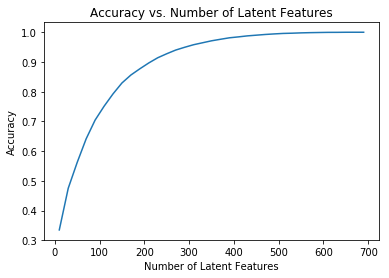

In [62]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [66]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_ids - all of the test user ids
    test_artcl - all of the test article ids
    
    '''
    # create user_item matrix into test and train
    user_item_train = create_user_item_matrix(df_train)   
    user_item_test = create_user_item_matrix(df_test)
    
    # Generate all test user ids
    test_ids = user_item_test.index.values
        
     # Generate all unique test article ids
    test_artcl = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_ids, test_artcl

user_item_train, user_item_test, test_ids, test_artcl = create_test_and_train_user_item(df_train, df_test)

In [68]:
# Answers for the questions below
print( 'How many users can we make predictions for in the test set?')
print(len(set(user_item_train.index).intersection(user_item_test.index)))

print( 'How many users in the test set are we not able to make predictions for because of the cold start problem?')
print(user_item_test.shape[0]-len(set(user_item_train.index).intersection(user_item_test.index)))

print( 'How many articles can we make predictions for in the test set?')
print(len(np.intersect1d(test_arts, user_item_train.columns.values)))

print( 'How many articles in the test set are we not able to make predictions for because of the cold start problem?')
print(len(test_arts) - len(np.intersect1d(test_arts, user_item_train.columns.values)))

How many users can we make predictions for in the test set?
20
How many users in the test set are we not able to make predictions for because of the cold start problem?
662
How many articles can we make predictions for in the test set?
574
How many articles in the test set are we not able to make predictions for because of the cold start problem?
0


In [70]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [71]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=0)

In [75]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
u_test = u_train[user_item_train.index.isin(test_idx),:]

vt_test = vt_train[:,user_item_train.columns.isin(test_arts)]

user_item_test_main = user_item_test[user_item_test.index.isin(set(user_item_train.index).intersection(user_item_test.index))]

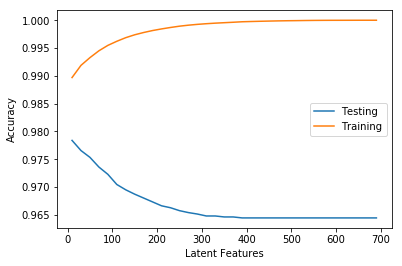

In [76]:
num_latent_feats = np.arange(10,700+10,20)
sum_train_errs = []
sum_test_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new, u_test_new, vt_test_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :], u_test[:,:k], vt_test[:k,:]
    
    # calculate dot product
    user_item_train_pred = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # test predictions
    user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))
    
    # compute error for each training prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_pred)
    
    # compute error for each testing prediction to actual value
    diffs_test = np.subtract(user_item_test_main, user_item_test_pred)

    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    test_err = np.sum(np.sum(np.abs(diffs_test)))

    sum_train_errs.append(train_err)
    sum_test_errs.append(test_err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_test_errs)/(user_item_test_main.shape[0] * user_item_test.shape[1]), label = 'Testing');
plt.plot(num_latent_feats, 1 - np.array(sum_train_errs)/(user_item_train.shape[0] * user_item_test.shape[1]), label = 'Training');
plt.legend()
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

From the picture abovewe can see that even though the accuracy on the training set increases, the accuracy on the test set is decreasing with more latent features.
Therefore the smallest amount of latent features is recommended.

There is alot of room for further improvements. For once the cold start problem is not properly adressed. Secondly the data lets us only recommend based on what users have interacted with certain articles. We do not know if the users liked the article. One easy next step could be to look at the interactions and favor articles where the users interacted multiple times with the same article. This could be a proxy that the article was interesting/useful beyond one single interaction.
More advanced models based on machine learning could also further improve the recommendations e.g. using unsupervised clustering to find groups of similar users.

<a id='conclusions'></a>

## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [78]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0